# 2021 Maps

In [1]:
import pandas as pd
import numpy as np
import cleandata as cd

In [2]:
df = pd.read_csv('../data/Gemeinde_Exekutive - daten.csv')

## Clean Data

In [3]:
df = cd.clean(df)

Jahrgänge nicht zugeordnet: 15
Partei nicht zugeordnet: 9
Keine Jahrgänge: 21


# QGIS export

## Aggregate different vectors

In [4]:
# Find strongest Party. "Multiple" when no single party is the stronges

df_g = df

df_g = pd.pivot_table(df_g, index='Gemeinde', columns='partei_c', values='Name', aggfunc='count').fillna(0)

def maxparty(row):
    maxi = 0
    maxs = ""
    multiple = False
    for i in df_g.columns:
        if i == 'partei_c': continue
        
        if row[i] == maxi:
            multiple = True
        elif row[i] > maxi:
            maxi = row[i]
            maxs = i
            multiple = False
            
    if multiple:
        return 'multiple'
    else:
        return maxs

df_g['topparty'] = df_g.apply(maxparty, axis=1)

# Add "Has Top Party": single, multi or parteilos
def add_has_topparty(x):
    if x == 'multiple': return 'multiple'
    elif x == 'parteilos': return 'parteilos'
    else: return 'single'

df_g['has_topparty'] = df_g['topparty'].apply(add_has_topparty)

df_export = df_g.reset_index()[['Gemeinde', 'topparty', 'has_topparty']].copy()

# Diese Parteien sind so oft die grösste Partei ihrer Gemeinde
df_g.reset_index().groupby('topparty').agg({'Gemeinde': 'count'}).sort_values('Gemeinde', ascending=False)

,Gemeinde
topparty,
parteilos,62
multiple,46
fdp,26
svp,19
sp,4
verschiedene,4
cvp,1


In [5]:
# Calc Partys percentage
df_g = pd.pivot_table(df, index='Gemeinde', columns='partei_c', values='Name', aggfunc='count').fillna(0)
df_g['total'] = df_g.sum(axis=1)

def calc_percentage(row):
    for i in df_g.columns:
        row[i] = round(100 / row['total'] * row[i], 1)
    return row

df_g = df_g.apply(calc_percentage, axis=1)

# Drop total
df_g.drop(columns='total', inplace=True)

df_export = df_export.merge(df_g.reset_index(), on='Gemeinde', how='left')

In [6]:
# Add m / w

df_g = pd.pivot_table(df, index='Gemeinde', columns='Geschlecht', values='Name', aggfunc='count')

df_g['total'] = df_g.sum(axis=1)
df_g['m'] = round(100 / df_g['total'] * df_g['m'])
df_g['w'] = round(100 / df_g['total'] * df_g['w'])

df_export = df_export.merge(df_g.reset_index()[['Gemeinde', 'm', 'w']], on='Gemeinde', how='left')

In [7]:
# Add m / w absolute

df_g = pd.pivot_table(df, index='Gemeinde', columns='Geschlecht', values='Name', aggfunc='count')

df_g.rename(columns={'m': 'm_abs', 'w': 'w_abs'}, inplace=True)

df_export = df_export.merge(df_g.reset_index()[['Gemeinde', 'm_abs', 'w_abs']], on='Gemeinde', how='left')

In [8]:
# Add age m / w

df_a = df[df.Alter.notna()].copy()
df_a['Alter'] = pd.to_numeric(df_a['Alter'])
df_g = pd.pivot_table(df_a, index='Gemeinde', columns='Geschlecht', values='Alter', aggfunc='mean')

df_g = df_g.apply(lambda x: round(x))

df_g.rename(columns={'m': 'age_m', 'w': 'age_w'}, inplace=True)

df_export = df_export.merge(df_g.reset_index(), on='Gemeinde', how='left')

In [9]:
# Add President Gender

df_a = df[df.Funktion == 'chair'].copy()

# Drop columns
df_a = df_a[['Gemeinde', 'Geschlecht']]

# Rename
df_a.rename(columns={'Geschlecht': 'chair_sex'}, inplace=True)

# Join
df_export = df_export.merge(df_a.reset_index(), on='Gemeinde', how='left')

In [10]:
# Agg General

df_a = df[df.Alter.notna()].copy()
df_a['Alter'] = pd.to_numeric(df_a['Alter'])

df_a = df_a.groupby('Gemeinde').agg({'Alter': 'mean'})

df_a['Alter'] = round(df_a['Alter'])

df_export = df_export.merge(df_a.reset_index(), on='Gemeinde', how='left')

df_export = df_export.set_index('Gemeinde')

## Join per GeoPandas and Export

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [12]:
gdf = gpd.read_file('../data/Gemeindegrenzen.gpkg', layer='UP_GEMEINDEN_F')

# Join
gdf = gdf.merge(df_export, left_on = 'GEMEINDENAME', right_on='Gemeinde', how='left')

# Export
gdf.to_file('../export/gemeinderaete.gpkg', driver='GPKG')

## Parteilose eher am Rande des Kantons (ländlich)

<AxesSubplot:>

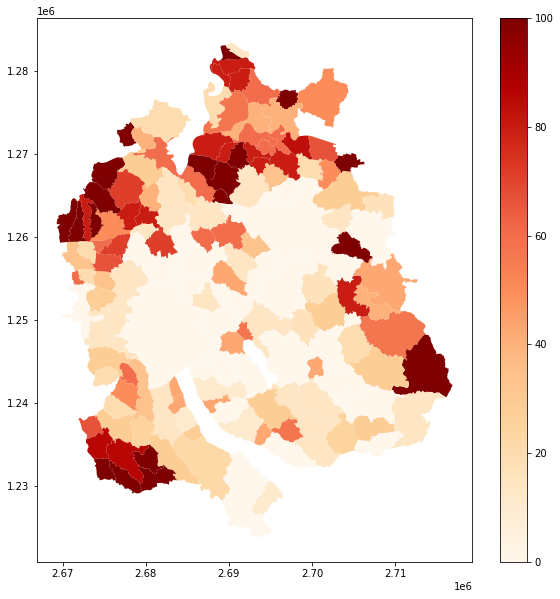

In [13]:
gdf.plot(column='parteilos', legend=True, figsize=(10, 10), cmap='OrRd')

## Welche Partei hat wo die Mehrheit?

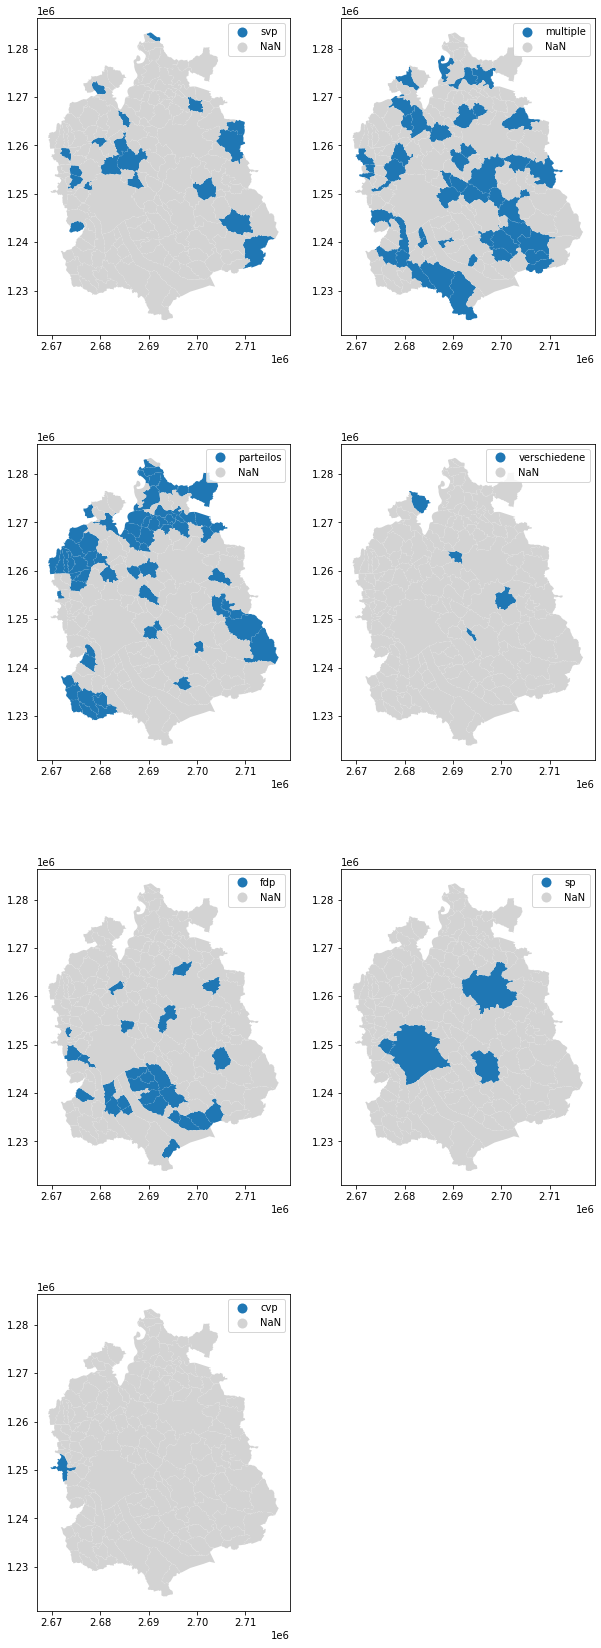

In [14]:
fig = plt.figure(figsize = (10, 30))

#fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

c = 1
for i, party in enumerate(gdf['topparty'].unique()):
    
    if not (type(party) == str): continue
    
    ax1 = fig.add_subplot(4, 2, c)
    gdf['leadingparty'] = gdf.topparty.apply(lambda x: party if x == party else None)
    gdf.plot(ax=ax1, column='leadingparty', missing_kwds={'color': 'lightgrey'}, legend=True)
    c += 1


## Wo sind Präsidentinnen?

<AxesSubplot:>

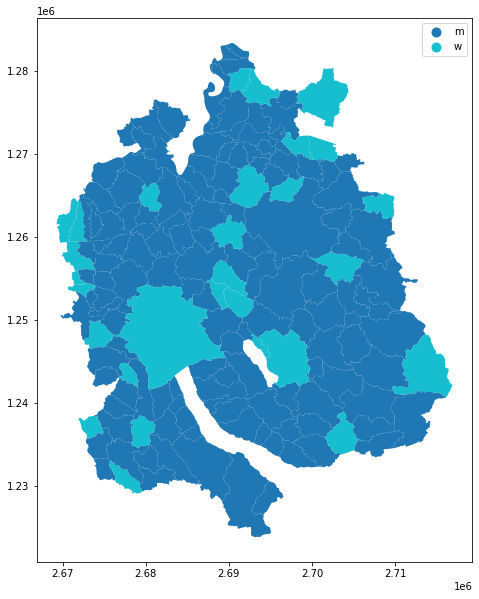

In [15]:
gdf.plot(column='chair_sex', legend=True, figsize=(10, 10))

## Wo ist Frauenanteil am grössten?

<AxesSubplot:>

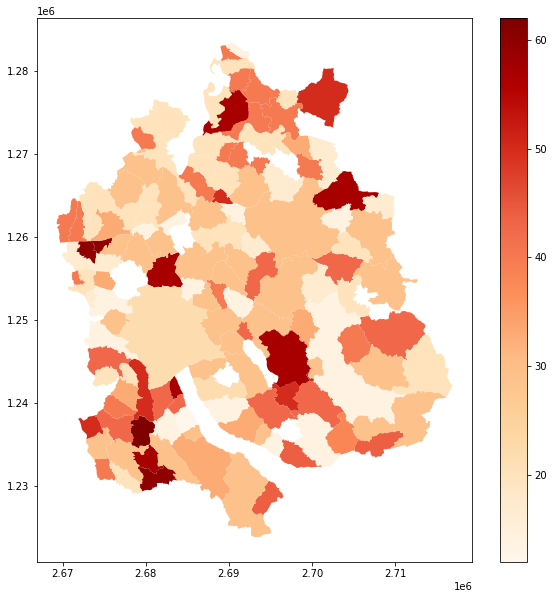

In [16]:
gdf.plot(column='w', legend=True, figsize=(10, 10), cmap='OrRd')

## Wo reine Männerbünde?

<AxesSubplot:>

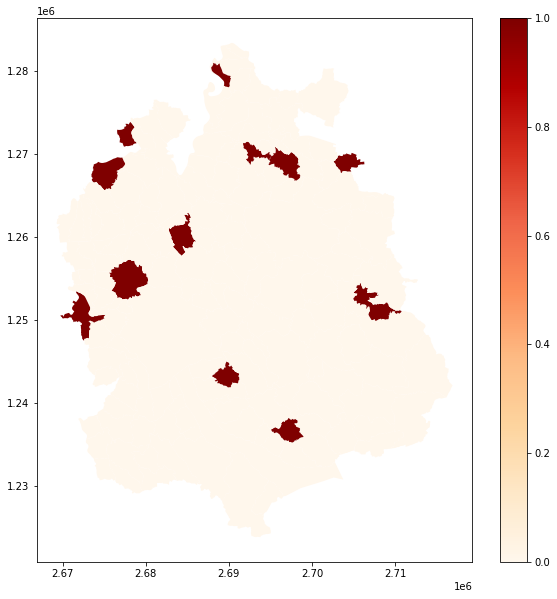

In [17]:
gdf['menonly'] = gdf['m'] == 100
gdf.plot(column='menonly', legend=True, figsize=(10, 10), cmap='OrRd')

<AxesSubplot:>

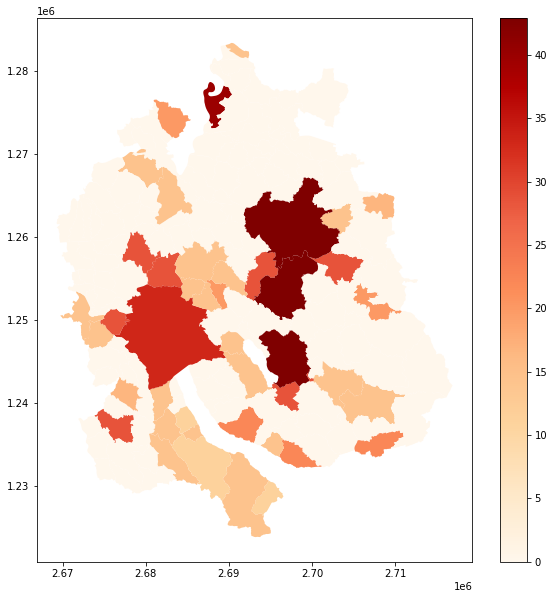

In [25]:
gdf.plot(column='sp', legend=True, figsize=(10, 10), cmap='OrRd')

In [16]:
gdf.dtypes

BFS                int64
ARPS               int64
BEZIRKSNAME       object
ART_TEXT          object
GEMEINDENAME      object
ART_CODE           int64
AREA_ROUND       float64
SHAPE_AREA       float64
SHAPE_LEN        float64
geometry        geometry
topparty          object
has_topparty      object
al               float64
bdp              float64
cvp              float64
edu              float64
evp              float64
fdp              float64
glp              float64
grüne            float64
parteilos        float64
sp               float64
svp              float64
vacant           float64
verschiedene     float64
m                float64
w                float64
m_abs            float64
w_abs            float64
age_m            float64
age_w            float64
index            float64
chair_sex         object
Alter            float64
dtype: object

## Export Men only and Frauenmehrheit

In [18]:
df_export = gdf[(gdf.menonly) | (gdf.w > 50)].copy()
df_export['Kategorie'] = 'Nur Männer'
df_export.loc[df_export.w > 50, 'Kategorie'] = 'Frauen in der Mehrheit'
df_export.loc[df_export.w > 50, 'text'] = df_export[df_export.w > 50].apply(lambda row: 'In <b>%s</b> sitzen <b>%s</b> Frauen und <b>%s</b> Männer im Gemeinderat.' % (row['GEMEINDENAME'], round(row['w_abs']), round(row['m_abs'])), axis=1)
df_export.loc[df_export.w.isna(), 'text'] = df_export[df_export.w.isna()].apply(lambda row: 'In <b>%s</b> sitzen <b>keine</b> Frauen im Gemeinderat.' % (row['GEMEINDENAME']), axis=1)

df_export = df_export[['BFS', 'GEMEINDENAME', 'Kategorie', 'text']]

df_export.rename(columns={'BFS': 'ID'}, inplace=True)

df_export.to_csv('../export/frauen_maenner_karte.csv')

## Export chairs

In [33]:
df_export = df[df.Funktion == 'chair'].copy()

# Add Text
def text(row):
    if row['Geschlecht'] == 'm':
        return "Präsident <b>%s</b>" % row['Name_cleaned']
    else:
        return "Präsidentin <b>%s</b>" % row['Name_cleaned']

df_export['text'] = df_export.apply(text, axis=1)

# Join
df_export = df_export.merge(gdf, left_on = 'Gemeinde', right_on = 'GEMEINDENAME', how='left')

df_export = df_export[['BFS', 'GEMEINDENAME', 'Geschlecht', 'text']]


df_export.rename(columns={'BFS': 'ID'}, inplace=True)

df_export.to_csv('../export/chair_sex.csv')



In [19]:
df_export = gdf.copy()

def text(row):
    if row['']

df_export['text'] = df_export.apply(lambda row: )

#df_export = df_export[['BFS', 'GEMEINDENAME', 'chair_sex']]
df_export.rename(columns={'BFS': 'ID'}, inplace=True)

df_export.to_csv('../export/chair_sex.csv')

In [34]:
gdf.head()

,BFS,ARPS,BEZIRKSNAME,ART_TEXT,GEMEINDENAME,ART_CODE,AREA_ROUND,SHAPE_AREA,SHAPE_LEN,geometry,...,w,m_abs,w_abs,age_m,age_w,index,chair_sex,Alter,leadingparty,menonly
0,216,97,Winterthur,Gemeinde,Dinhard,1,7070153.0,7.070153e+06,16695.815324,"POLYGON ((2700078.573 1269326.979, 2700144.692...",...,40.0,3.0,2.0,65.0,52.0,224.0,m,60.0,None,False
1,172,75,Pfäffikon,Gemeinde,Fehraltorf,1,9470506.0,9.470506e+06,18005.488182,"POLYGON ((2699148.215 1251281.127, 2699148.082...",...,33.0,4.0,2.0,62.0,56.0,1006.0,m,60.0,None,False
2,31,128,Andelfingen,Gemeinde,Henggart,1,3032908.0,3.032908e+06,10759.322334,"POLYGON ((2694837.402 1269257.656, 2694836.727...",...,40.0,3.0,2.0,59.0,59.0,499.0,m,59.0,None,False
3,33,130,Andelfingen,Gemeinde,Kleinandelfingen,1,10293234.0,1.029323e+07,23001.760634,"POLYGON ((2693946.551 1275895.351, 2693947.988...",...,40.0,3.0,2.0,51.0,51.0,890.0,m,51.0,None,False
4,94,69,Dielsdorf,Gemeinde,Otelfingen,1,7146621.0,7.146621e+06,17550.929702,"POLYGON ((2673895.467 1256806.610, 2673895.600...",...,17.0,5.0,1.0,50.0,53.0,877.0,w,51.0,None,False


In [20]:
df_export

,ID,GEMEINDENAME,chair_sex
0,216,Dinhard,m
1,172,Fehraltorf,m
2,31,Henggart,m
3,33,Kleinandelfingen,m
4,94,Otelfingen,w
...,...,...,...
162,224,Pfungen,m
163,25,Dachsen,m
164,29,Flurlingen,m
165,27,Feuerthalen,m


In [21]:
gdf.head()

,BFS,ARPS,BEZIRKSNAME,ART_TEXT,GEMEINDENAME,ART_CODE,AREA_ROUND,SHAPE_AREA,SHAPE_LEN,geometry,...,w,m_abs,w_abs,age_m,age_w,index,chair_sex,Alter,leadingparty,menonly
0,216,97,Winterthur,Gemeinde,Dinhard,1,7070153.0,7.070153e+06,16695.815324,"POLYGON ((2700078.573 1269326.979, 2700144.692...",...,40.0,3.0,2.0,65.0,52.0,224.0,m,60.0,None,False
1,172,75,Pfäffikon,Gemeinde,Fehraltorf,1,9470506.0,9.470506e+06,18005.488182,"POLYGON ((2699148.215 1251281.127, 2699148.082...",...,33.0,4.0,2.0,62.0,56.0,1006.0,m,60.0,None,False
2,31,128,Andelfingen,Gemeinde,Henggart,1,3032908.0,3.032908e+06,10759.322334,"POLYGON ((2694837.402 1269257.656, 2694836.727...",...,40.0,3.0,2.0,59.0,59.0,499.0,m,59.0,None,False
3,33,130,Andelfingen,Gemeinde,Kleinandelfingen,1,10293234.0,1.029323e+07,23001.760634,"POLYGON ((2693946.551 1275895.351, 2693947.988...",...,40.0,3.0,2.0,51.0,51.0,890.0,m,51.0,None,False
4,94,69,Dielsdorf,Gemeinde,Otelfingen,1,7146621.0,7.146621e+06,17550.929702,"POLYGON ((2673895.467 1256806.610, 2673895.600...",...,17.0,5.0,1.0,50.0,53.0,877.0,w,51.0,None,False
